## Utilities Functions & Steups

In [1]:
import httpx
from langsmith import traceable
from typing import Dict, Any, List, Union, Optional
from markdownify import markdownify
from duckduckgo_search import DDGS

def fetch_raw_content(url: str) -> Optional[str]:
    """
    Fetch HTML content from a URL and convert it to markdown format.
    
    Uses a 10-second timeout to avoid hanging on slow sites or large pages.
    
    Args:
        url (str): The URL to fetch content from
        
    Returns:
        Optional[str]: The fetched content converted to markdown if successful,
                      None if any error occurs during fetching or conversion
    """
    try:                
        # Create a client with reasonable timeout
        with httpx.Client(timeout=10.0) as client:
            response = client.get(url)
            response.raise_for_status()
            return markdownify(response.text)
    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.
    
    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results
            
    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")
    
    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source
    
    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()

def format_sources(search_results):
    """Format search results into a bullet-point list of sources.
    
    Args:
        search_results (dict): Tavily search response containing results
        
    Returns:
        str: Formatted string with sources and their URLs
    """
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

@traceable
def duckduckgo_search(query: str, max_results: int = 3, fetch_full_page: bool = False) -> Dict[str, List[Dict[str, Any]]]:
    """
    Search the web using DuckDuckGo and return formatted results.
    
    Uses the DDGS library to perform web searches through DuckDuckGo.
    
    Args:
        query (str): The search query to execute
        max_results (int, optional): Maximum number of results to return. Defaults to 3.
        fetch_full_page (bool, optional): Whether to fetch full page content from result URLs. 
                                         Defaults to False.
    Returns:
        Dict[str, List[Dict[str, Any]]]: Search response containing:
            - results (list): List of search result dictionaries, each containing:
                - title (str): Title of the search result
                - url (str): URL of the search result
                - content (str): Snippet/summary of the content
                - raw_content (str or None): Full page content if fetch_full_page is True,
                                            otherwise same as content
    """
    try:
        with DDGS() as ddgs:
            results = []
            search_results = list(ddgs.text(query, max_results=max_results))
            
            for r in search_results:
                url = r.get('href')
                title = r.get('title')
                content = r.get('body')
                
                if not all([url, title, content]):
                    print(f"Warning: Incomplete result from DuckDuckGo: {r}")
                    continue

                raw_content = content
                if fetch_full_page:
                    raw_content = fetch_raw_content(url)
                
                # Add result to list
                result = {
                    "title": title,
                    "url": url,
                    "content": content,
                    "raw_content": raw_content
                }
                results.append(result)
            
            return {"results": results}
    except Exception as e:
        print(f"Error in DuckDuckGo search: {str(e)}")
        print(f"Full error details: {type(e).__name__}")
        return {"results": []}

---

## Define Local Model

Qwen3

In [2]:
# imports
from langchain_ollama import ChatOllama

# instantiate the model
local_llm = "qwen3:8b-q4_K_M"
llm  = ChatOllama(model = local_llm, temperature = 0)

# set llm json 
llm_json_mode = ChatOllama(model = local_llm, temperature = 0, format='json')

llm_json_mode

ChatOllama(model='qwen3:8b-q4_K_M', temperature=0.0, format='json')

## Define States
* State refers to moment.
* State preserve all the info in the course of lifetime of agent.
* 3 states - `SummaryState` (store agent req data), `SummaryStateInput` (user req data), `SummaryStateOutput` (store agent output)

In [3]:
# imports
import operator
from dataclasses import dataclass, field
from typing import TypedDict, Annotated, Literal # to impose dtype restrictions

In [4]:
# create summary state data class - core & preserves all important information
# for assistant
@dataclass(kw_only=True)
class SummaryState:
    """Summary state data class."""
    research_topic: str = field(default=None) # report topic
    search_query: str = field(default=None) # search query
    web_research_results : Annotated[list, operator.add] = field(default_factory=list) # web research results
    sources_gathered : Annotated[list, operator.add] = field(default_factory=list) # sources gathered (urls)
    research_loop_count : int = field(default=0) # research loop count - for iteration tracking
    final_summary: str = field(default=None) # final report

SummaryState

__main__.SummaryState

In [5]:
# create a summary state input object to let user define the research topic
dataclass(kw_only=True)
class SummaryStateInput(TypedDict):
    """user input"""
    research_topic: str = field(default=None) # report topic

SummaryStateInput

__main__.SummaryStateInput

In [6]:
# create a summary state output object to store all the output info
@dataclass(kw_only=True)
class SummaryStateOutput(TypedDict):
    """Summary output"""
    final_summary: str = field(default=None) # Final report

SummaryStateOutput

__main__.SummaryStateOutput

## Define All Prompts
* Defines how model should act, think of it giving action
* Most Important part of any AI Agent Flow 
* Defines :
    * Qwery Writer Prompt
    * Summariser Instruction Prompt
    * Reflection Prompt

In [7]:
# qwery writer prompt - model feeding prompt
query_writer_prompt="""Your goal is to generate targeted web search query.
The query will gather information related to a specific topic.

Topic:
{research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""
# rationale - why this query is important. incourages model to think about generation of a query itself
query_writer_prompt

'Your goal is to generate targeted web search query.\nThe query will gather information related to a specific topic.\n\nTopic:\n{research_topic}\n\nReturn your query as a JSON object:\n{{\n    "query": "string",\n    "aspect": "string",\n    "rationale": "string"\n}}\n'

In [8]:
# summarizer instructions prompt - 1st summarisation
summarizer_instructions_prompt="""Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered
2. Maintain consistency with the existing content's style and depth
3. Only add new, non-redundant information
4. Ensure smooth transitions between existing and new content

When creating a NEW summary:
1. Highlight the most relevant information from each source
2. Provide a concise overview of the key points related to the report topic
3. Emphasize significant findings or insights
4. Ensure a coherent flow of information

In both cases:
- Focus on factual, objective information
- Maintain a consistent technical depth
- Avoid redundancy and repetition
- DO NOT use phrases like "based on the new results" or "according to additional sources"
- DO NOT add a preamble like "Here is an extended summary ..." Just directly output the summary.
- DO NOT add a References or Works Cited section.
"""

summarizer_instructions_prompt

'Your goal is to generate a high-quality summary of the web search results.\n\nWhen EXTENDING an existing summary:\n1. Seamlessly integrate new information without repeating what\'s already covered\n2. Maintain consistency with the existing content\'s style and depth\n3. Only add new, non-redundant information\n4. Ensure smooth transitions between existing and new content\n\nWhen creating a NEW summary:\n1. Highlight the most relevant information from each source\n2. Provide a concise overview of the key points related to the report topic\n3. Emphasize significant findings or insights\n4. Ensure a coherent flow of information\n\nIn both cases:\n- Focus on factual, objective information\n- Maintain a consistent technical depth\n- Avoid redundancy and repetition\n- DO NOT use phrases like "based on the new results" or "according to additional sources"\n- DO NOT add a preamble like "Here is an extended summary ..." Just directly output the summary.\n- DO NOT add a References or Works Cite

In [9]:
# reflection prompt - for agents internal thinking
reflection_instructions_prompt = """You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration
2. Generate a follow-up question that would help expand your understanding
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{ 
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}"""

reflection_instructions_prompt

'You are an expert research assistant analyzing a summary about {research_topic}.\n\nYour tasks:\n1. Identify knowledge gaps or areas that need deeper exploration\n2. Generate a follow-up question that would help expand your understanding\n3. Focus on technical details, implementation specifics, or emerging trends that weren\'t fully covered\n\nEnsure the follow-up question is self-contained and includes necessary context for web search.\n\nReturn your analysis as a JSON object:\n{{ \n    "knowledge_gap": "string",\n    "follow_up_query": "string"\n}}'

## Define Functional Nodes
* Defined functions / nodes to exectue tasks
* Defines:
    * `generate_query` - generates intial query and feds to model
    * `web_research` - performs web research
    * `summarise_sources` - internally generate summarises
    * `reflect_on_summary` - think about summary, if require redo web research
    * `finalise_summary` - give the final output

In [10]:
import json
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from configuration import Configuration

In [11]:
# generate query node
def generate_query(state: SummaryState):
    """ Generate a query for web search """
    
    # Format the prompt
    query_writer_instructions_formatted = query_writer_prompt.format(research_topic=state.research_topic)

    # Generate a query
    result = llm_json_mode.invoke(
        [SystemMessage(content=query_writer_instructions_formatted),
        HumanMessage(content=f"Generate a query for web search:")]
    )   
    query = json.loads(result.content)
    
    return {"search_query": query['query']}

In [ ]:
# from ollama_deep_researcher.configuration import Configuration, SearchAPI

def web_research(state: SummaryState):
    """ Gather information from the web """
    # Search the web
    search_results = duckduckgo_search(state.search_query, max_results=3, fetch_full_page=True)
    search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000)
    return {"sources_gathered": [format_sources(search_results)], "research_loop_count": state.research_loop_count + 1, "web_research_results": [search_str]}

In [13]:
def summarize_sources(state: SummaryState):
    """ Summarize the gathered sources """
    
    # Existing summary
    existing_summary = state.final_summary

    # Most recent web research
    most_recent_web_research = state.web_research_results[-1]

    # Build the human message
    if existing_summary:
        human_message_content = (
            f"Extend the existing summary: {existing_summary}\n\n"
            f"Include new search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )
    else:
        human_message_content = (
            f"Generate a summary of these search results: {most_recent_web_research} "
            f"That addresses the following topic: {state.research_topic}"
        )

    # Run the LLM
    result = llm.invoke(
        [SystemMessage(content=summarizer_instructions_prompt),
        HumanMessage(content=human_message_content)]
    )

    final_summary = result.content
    return {"final_summary": final_summary}


In [14]:
def reflect_on_summary(state: SummaryState):
    """ Reflect on the summary and generate a follow-up query """

    # Generate a query
    result = llm_json_mode.invoke(
        [SystemMessage(content=reflection_instructions_prompt.format(research_topic=state.research_topic)),
        HumanMessage(content=f"Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge: {state.final_summary}")]
    )   
    follow_up_query = json.loads(result.content)

    # Overwrite the search query
    return {"search_query": follow_up_query['follow_up_query']}

In [15]:
def finalize_summary(state: SummaryState):
    """ Finalize the summary """
    
    # Format all accumulated sources into a single bulleted list
    all_sources = "\n".join(source for source in state.sources_gathered)
    state.final_summary = f"## Summary\n\n{state.final_summary}\n\n ### Sources:\n{all_sources}"
    return {"final_summary": state.final_summary}

def route_research(state: SummaryState, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    """ Route the research based on the follow-up query """

    configurable = Configuration.from_runnable_config(config)
    if state.research_loop_count <= configurable.max_web_research_loops:
        return "web_research"
    else:
        return "finalize_summary" 

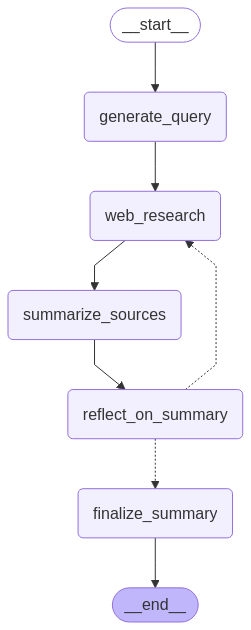

In [16]:
# Add nodes and edges 
builder = StateGraph(SummaryState, input=SummaryStateInput, output=SummaryStateOutput, config_schema=Configuration)
builder.add_node("generate_query", generate_query)
builder.add_node("web_research", web_research)
builder.add_node("summarize_sources", summarize_sources)
builder.add_node("reflect_on_summary", reflect_on_summary)
builder.add_node("finalize_summary", finalize_summary)


# Add edges
builder.add_edge(START, "generate_query")
builder.add_edge("generate_query", "web_research")
builder.add_edge("web_research", "summarize_sources")
builder.add_edge("summarize_sources", "reflect_on_summary")
builder.add_conditional_edges("reflect_on_summary", route_research) # conditional to wether to continue research or finalize
builder.add_edge("finalize_summary", END)

# compile the graph
graph = builder.compile()

graph

## Test
Time to test the model

In [22]:
research_input = SummaryStateInput(
    research_topic="Benifits of Panner"
)
summary = graph.invoke(research_input)

In [ ]:
# # test the output
# research_input = SummaryStateInput(
#     research_topic="Benifits of Paneer"
# )
# summary = graph.invoke(research_input)

In [ ]:
# import re
# cleaned_summary = re.sub(r'<think>.*?</think>', '', summary['final_summary'], flags=re.DOTALL)
# cleaned_summary = re.sub(r'\n{3,}', '\n\n', cleaned_summary)
# print(cleaned_summary)

## Summary

Paneer, a popular dairy product in Indian cuisine, offers several health benefits. Here's a concise overview based on the provided sources:

### **Key Benefits of Paneer**  
1. **Rich in Protein and Calcium**  
   - Paneer is an excellent source of **protein**, essential for muscle repair, growth, and overall body function.  
   - It also provides **calcium**, supporting bone health and preventing conditions like osteoporosis.  

2. **Nutrient-Dense**  
   - Contains other vital nutrients such as **vitamin B12**, **phosphorus**, and **iron**, which contribute to energy metabolism, blood health, and immune function.  

3. **Supports Weight Management**  
   - Despite being calorie-dense, paneer’s high protein content can promote satiety, helping control appetite and support weight management when consumed in moderation.  

4. **Versatile in Recipes**  
   - Can be used in a wide variety of Indian dishes (e.g., butter chicken, paneer tikka, aloo paratha) and is a staple in ve